In [63]:
import pandas as pd
import numpy as np

import kerastuner as kt

import pprint

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.callbacks as callbacks

import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizers

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

from datetime import datetime
import time

In [2]:
from imblearn.over_sampling import RandomOverSampler

In [3]:
dataset_path = "..\clothing-dataset\images.csv"

In [4]:
dataset = pd.read_csv(dataset_path)

In [5]:
gb_categories = dataset.groupby('label').count()

<AxesSubplot:xlabel='label'>

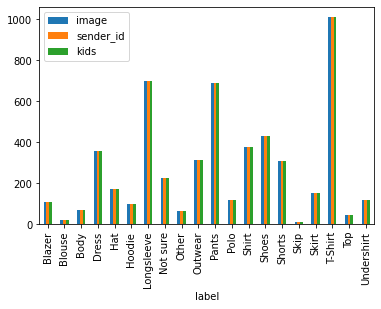

In [6]:
gb_categories.plot.bar()

In [7]:
gb_categories[gb_categories['image'] > 200]

,image,sender_id,kids
label,,,
Dress,357,357,357
Longsleeve,699,699,699
Not sure,228,228,228
Outwear,312,312,312
Pants,692,692,692
Shirt,378,378,378
Shoes,431,431,431
Shorts,308,308,308
T-Shirt,1011,1011,1011


In [8]:
dict_labels = {'T-Shirt':0, 'Pants':1, 'Longsleeve':2, 'Dress':3, 'Shoes':4}

In [9]:
dataset = dataset.query(f"label in {[*dict_labels]}")

In [10]:
df_main = dataset[['image','label']]

In [11]:
df_main['y'] = df_main['label'].replace(dict_labels)

C:\Users\Qasim\AppData\Local\Temp/ipykernel_2068/445683494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['y'] = df_main['label'].replace(dict_labels)


In [12]:
df_main['img_path'] = df_main['image'].apply(lambda x: f"../clothing-dataset/images/{x}.jpg")

In [13]:
dataset = []

In [14]:
img_w, img_h = 64, 64

In [15]:
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(img_w,img_h))
	# img = load_img(filename, target_size=(64,64,1))
	
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(img_w, img_h, 1)
	# prepare pixel data
	img = img.astype('float32')

	# img = 255 - img
	# img[img < 20] = 0
	img = img / 255.0
	# img = img.astype(int)
	return img

In [16]:
for i,r in df_main.iterrows():
    try:
        im = load_image(r['img_path'])
        dataset.append([im,r['y']])
    except:
        print(f"error img -> {r['img_path']}")

c:\Users\Qasim\anaconda3\envs\ai-env\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [17]:
dataset = np.array(dataset)

C:\Users\Qasim\AppData\Local\Temp/ipykernel_2068/1525633772.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  dataset = np.array(dataset)


In [18]:
dataset.shape

(3190, 2)

In [19]:
# conver to right data type as errors show up for incorrect type in model building
X = np.stack(dataset[:,0]).astype('float32')
y = dataset[:,1].astype('uint8')

In [20]:

reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomOverSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
X = oversampled_X.reshape(-1,img_w,img_h,1)


In [22]:
y = oversampled_y

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.05, random_state=42)

In [24]:
x_train.shape

(4802, 64, 64, 1)

In [49]:
model = tf.keras.models.Sequential()

In [50]:
model.add(
    tf.keras.layers.Conv2D(
        filters=32, # filters to learn
        kernel_size=(5,5),
        strides=(1,1),
        padding='valid',
        activation='relu',
        input_shape=(img_w,img_h,1)
    )
)

In [51]:
model.add(
    tf.keras.layers.Conv2D(
        filters=32, # filters to learn
        kernel_size=(5,5),
        strides=(1,1),
        padding='valid',
        activation='relu',
        input_shape=(img_w,img_h,1)
    )
)

In [52]:
# model.add(tf.keras.layers.experimental.preprocessing.Resizing(224,224, interpolation='nearest'))

In [53]:
# feature_extractor = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
# feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape = (224, 224,3))
# feature_extractor_layer.trainable = False
# model.add(feature_extractor_layer)

In [54]:
# The next layer we will add is a Maxpooling layer. This will reduce the 
# dimensionality of each feature, which reduces the number of parameters that 
# the model needs to learn, which shortens training time.
model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), # Size feature will be mapped to
        strides=(2, 2) # How the pool "steps" across the feature
    )
)

In [55]:
# We'll now add a dropout layer. This fights overfitting and forces the model to 
# learn multiple representations of the same data by randomly disabling neurons 
# in the learning phase.
model.add(
    tf.keras.layers.Dropout(
        rate=0.30 # Randomly disable 25% of neurons
    )
)
# model.add(
#     tf.keras.layers.Dropout(
#         rate=0.25 # Randomly disable 25% of neurons
#     )
# )


# Output from previous layer is a 3D tensor. This must be flattened to a 1D 
# vector before beiung fed to the Dense Layers.
model.add(
    tf.keras.layers.Flatten()
)

# A dense (interconnected) layer is added for mapping the derived features 
# to the required class.
model.add(
    tf.keras.layers.Dense(
        units=32, # Output shape
        activation='relu' # Rectified Linear Unit Activation Function
    )
)

# Final layer with 10 outputs and a softmax activation. Softmax activation 
# enables me to calculate the output based on the probabilities. 
# Each class is assigned a probability and the class with the maximum 
# probability is the model’s output for the input.
model.add(
    tf.keras.layers.Dense(
        units=5, # Output shape
        activation='softmax' # Softmax Activation Function
    )
)

# Build the model
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimizer function
    metrics=['accuracy'] # reporting metric
)

# Display a summary of the models structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 60, 32)        832       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                802848    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

In [56]:
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# Train the CNN on the training data
history = model.fit(
    
      # Training data : features (images) and classes.
      x_train, y_train,
                    
      # number of samples to work through before updating the 
      # internal model parameters via back propagation.
      batch_size=100, 

      # An epoch is an iteration over the entire training data.
      epochs=50, 

      # The model will set apart his fraction of the training 
      # data, will not train on it, and will evaluate the loss
      # and any model metrics on this data at the end of 
      # each epoch. 
      validation_split=0.3, 
      callbacks=[early_stopping],
      verbose=1) 

Epoch 1/50
34/34 [==============================] - 1s 23ms/step - loss: 1.4996 - accuracy: 0.3761 - val_loss: 1.1646 - val_accuracy: 0.5850
Epoch 2/50
34/34 [==============================] - 1s 16ms/step - loss: 0.9798 - accuracy: 0.6510 - val_loss: 0.8256 - val_accuracy: 0.7134
Epoch 3/50
34/34 [==============================] - 1s 16ms/step - loss: 0.6736 - accuracy: 0.7679 - val_loss: 0.6374 - val_accuracy: 0.7876
Epoch 4/50
34/34 [==============================] - 1s 16ms/step - loss: 0.4902 - accuracy: 0.8399 - val_loss: 0.5306 - val_accuracy: 0.8272
Epoch 5/50
34/34 [==============================] - 1s 16ms/step - loss: 0.3729 - accuracy: 0.8798 - val_loss: 0.5043 - val_accuracy: 0.8411
Epoch 6/50
34/34 [==============================] - 1s 15ms/step - loss: 0.3061 - accuracy: 0.9021 - val_loss: 0.4787 - val_accuracy: 0.8536
Epoch 7/50
34/34 [==============================] - 1s 16ms/step - loss: 0.2431 - accuracy: 0.9244 - val_loss: 0.4617 - val_accuracy: 0.8640
Epoch 8/50
34

In [ ]:
## Model 2

In [64]:
def model4(hp):
    model = Sequential()
    model.add(layers.Input((img_w, img_h,1)))

    hp_fe_11 = hp.Int('filter_exp_11', min_value=3, max_value=7, step=1)
    hp_fe_12 = hp.Int('filter_exp_12', min_value=3, max_value=7, step=1)
    hp_fs_11 = hp.Int('filter_size_11',  min_value=2, max_value=6, step=1)
    hp_fs_12 = hp.Int('filter_size_12',  min_value=2, max_value=6, step=1)
    hp_mps_1 = hp.Int('max_pool_size_1', min_value=2, max_value=6, step=1)

    model.add(layers.Conv2D(2**hp_fe_11, hp_fs_11, padding='same', activation='relu'))
    model.add(layers.Conv2D(2**hp_fe_12, hp_fs_12, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(hp_mps_1))
    model.add(layers.Dropout(0.2))

    hp_dense_exp_1 = hp.Int('dense_exp_1', min_value=5, max_value=9, step=1)
    model.add(layers.Flatten())
    model.add(layers.Dense(units=2**hp_dense_exp_1, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(5, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(),
                    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

    return model

In [65]:
# We used Keras Tuner, to find the best hyperparameters for our models
def model_tuner(model_builder, dir):

    tuner = kt.Hyperband(model_builder,
                        objective='val_accuracy',
                        max_epochs=10,
                        factor=3)

    early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    tuner.search(x_train, y_train, validation_split=0.3, epochs=50, callbacks=[early_stopping])
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    pp = pprint.PrettyPrinter(indent=1)
    print("\n-- Best Model Hyper params --\n ")
    pp.pprint(best_hps.values)

    model = tuner.hypermodel.build(best_hps)

    print("\n-- Model Performance --\n ")
    

    history = model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping], validation_split=0.3, verbose=2)
    score, acc = model.evaluate(x_test, y_test)
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) 
    print()
    print('Best epoch  : %d' % (best_epoch,))
    print("Best val acc: %s" % (round(max(history.history['val_accuracy']), 4)))
    print("    Test acc: %s" % (round(acc, 4)))

    return model

In [66]:
trained_model_4 = model_tuner(model4, 'model4')

Trial 30 Complete [00h 00m 10s]
val_accuracy: 0.8882720470428467

Best val_accuracy So Far: 0.9111728072166443
Total elapsed time: 00h 02m 59s
INFO:tensorflow:Oracle triggered exit

-- Best Model Hyper params --
 
{'dense_exp_1': 8,
 'filter_exp_11': 4,
 'filter_exp_12': 6,
 'filter_size_11': 3,
 'filter_size_12': 4,
 'max_pool_size_1': 5,
 'tuner/bracket': 0,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/round': 0}

-- Model Performance --
 
Epoch 1/50
106/106 - 1s - loss: 1.2057 - accuracy: 0.5162 - val_loss: 0.8907 - val_accuracy: 0.6801
Epoch 2/50
106/106 - 1s - loss: 0.6964 - accuracy: 0.7608 - val_loss: 0.5856 - val_accuracy: 0.7988
Epoch 3/50
106/106 - 1s - loss: 0.4647 - accuracy: 0.8450 - val_loss: 0.4833 - val_accuracy: 0.8473
Epoch 4/50
106/106 - 1s - loss: 0.3337 - accuracy: 0.8869 - val_loss: 0.4291 - val_accuracy: 0.8563
Epoch 5/50
106/106 - 1s - loss: 0.2398 - accuracy: 0.9206 - val_loss: 0.4012 - val_accuracy: 0.8765
Epoch 6/50
106/106 - 1s - loss: 0.1795 - ac

In [67]:
trained_model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2359552   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [68]:
trained_model_4.save('best_model.h5')

In [69]:
model = tf.keras.models.load_model('./best_model.h5')

In [73]:
lookup[np.argmax(model.predict(test_img.reshape(1,64,64,1)))]

'Shoes'

In [46]:
lookup = {value: key for key, value in dict_labels.items()}

In [ ]:
plt.imshow(x_test[0])
plt.title(lookup[y_test[0]])
plt.show()

In [ ]:
test_img = x_test[0]

In [ ]:
test_img1 = load_image("../clothing-dataset/images/0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg")

In [ ]:
img = load_img("../clothing-dataset/images/0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg")

In [ ]:
plt.imshow(test_img1)

In [ ]:
predicted = lookup[np.argmax(model.predict(test_img1.reshape(1,64,64,1)))]
actual = lookup[y_test[0]]

"predicted: "+  predicted, "actual: "+ actual

In [26]:
from collections import Counter

In [77]:
Counter(y_test)

Counter({0: 45, 1: 38, 3: 18, 4: 20, 2: 39})

In [27]:
Counter(y_test)

Counter({3: 43, 2: 48, 1: 55, 4: 44, 0: 63})

In [29]:
Counter(y)

Counter({0: 1011, 4: 1011, 1: 1011, 3: 1011, 2: 1011})

In [40]:
img = load_image('../clothing-dataset/unknown.png')

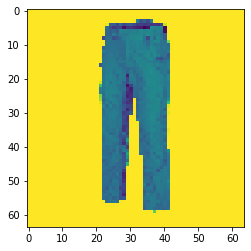

In [41]:
plt.imshow(img)

In [47]:
lookup[np.argmax(model.predict(img.reshape(1,64,64,1)))]

'Pants'